<a href="https://colab.research.google.com/github/happyhyowon/work/blob/master/HyowonKim_2019020723_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: right"> __Provided on May 14, Due on May 27__ [BRI516, Spring/2019] </div>

For homework in general:
* Install `Anaconda` and create an environment with `NumPy`, `Pandas`, `Matplotlib`, `scikit-learn` in Python 3.5 
* Please upload your jupyter-notebook file for homework to `Blackboard`
* Please visualize the results as much as possible and discuss your results at least one line of text

### [HW04]

#### Clustering Analysis (CH. 11)

##### (1) Data preparation
    Generate four isotropic Gaussian blobs with 400 2D samples and with cluster standard deviation of 0.5




### * Generate isotropic Gaussian blobs for clustering.

In [24]:
from sklearn.datasets.samples_generator import make_blobs
import numpy as np

# Generate isotropic Gaussian blobs for clustering.
X, y = make_blobs(n_samples=400, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

In [25]:
#help(make_blobs)

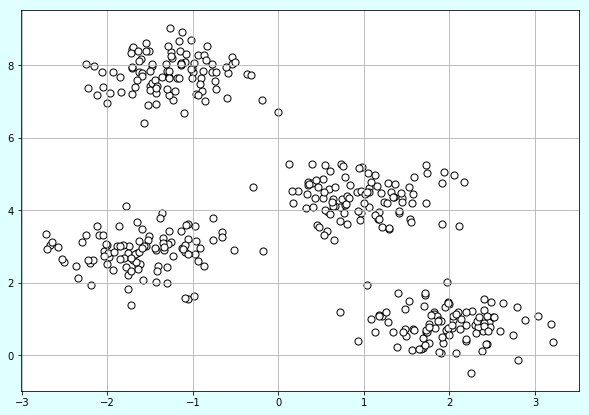

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 7))
fig.patch.set_facecolor('lightcyan')
plt.scatter(X[:, 0], X[:, 1], c='white', marker='o', edgecolor='black', s=50)
plt.grid()
plt.show()

##### (2) k-means
    (2a) Implement the k-means algorithm using generic python code (i.e., not using the scikit-learn)



[[ 2.438599    1.0758101 ]
 [-0.8619084   7.004661  ]
 [-0.17879198  2.88092   ]
 [ 1.5914154   4.9049773 ]]


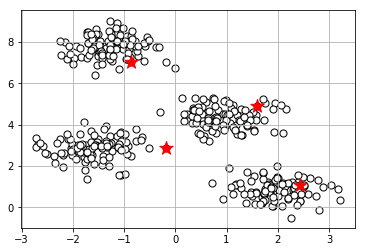

[init] squared Euclidean distance : 0.0


[loop:1]
 squared Euclidean distance : 0.0 
 new Centers :
[[ 1.9824926   0.83824116]
 [-1.2655171   7.7693114 ]
 [-1.3249292   2.9668443 ]
 [ 1.0343946   4.448151  ]]


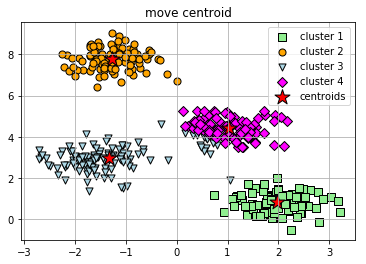

[loop:2]
 squared Euclidean distance : 0.0 
 new Centers :
[[ 1.9730669   0.84915787]
 [-1.2655171   7.7693114 ]
 [-1.599209    2.8600628 ]
 [ 0.9547205   4.357919  ]]


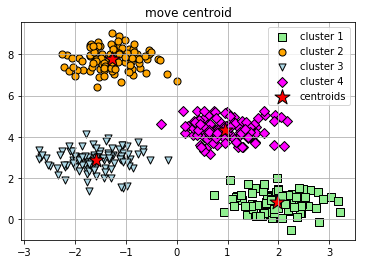

[loop:3]
 squared Euclidean distance : 0.0 
 new Centers :
[[ 1.9730669   0.84915787]
 [-1.2655171   7.7693114 ]
 [-1.599209    2.8600628 ]
 [ 0.9547205   4.357919  ]]


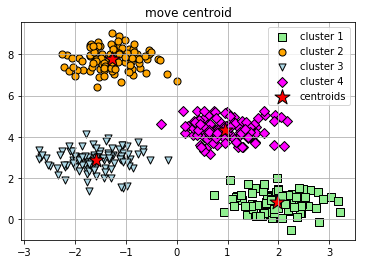

In [31]:
from copy import deepcopy
import random as rd

bVerbose = True

# Euclidean Distance Caculator
def dist(a, b, axis=1):
    return np.linalg.norm((a - b), axis=axis)

# Number of clusters
k = 4
tol=1e-04
max_iter = 100

n = X.shape[0] # num of training data

## 1. Randomly pick k centroids from the sample points as initial cluster centers.
xx = []
xx.extend([rd.randrange(0,n+1), rd.randrange(0,n+1), rd.randrange(0,n+1), rd.randrange(0,n+1)])
# X coordinates of random centroids
c_x = []
c_x.extend([X[xx[0],0], X[xx[1],0], X[xx[2],0], X[xx[3],0]])
# Y coordinates of random centroids
c_y = []
c_y.extend([X[xx[0],1], X[xx[1],1], X[xx[2],1], X[xx[3],1]])

centers = np.array(list(zip(c_x, c_y)), dtype=np.float32)

if bVerbose == True:
    print(centers)
if bVerbose == True:
    # Plotting along with the Centroids
    plt.scatter(X[:, 0], X[:, 1], c='white', marker='o', edgecolor='black', s=50)
    plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=200, c='r')
    plt.grid()
    plt.show()

clusters = np.zeros(n)
pCenters = np.zeros(centers.shape) # old Center
nCenters = deepcopy(centers) # new Center

# squared Euclidean distance
error = dist(nCenters, pCenters, None)
if bVerbose == True:
    print('[init] squared Euclidean distance : {}\n\n' .format(error))

## 4. Repeat steps 2 and 3  until the cluster assignments do not change or 
##    a user defined tolerance or maximum number of iterations is reached.
cnt = 0
while error > tol:
    if cnt >= max_iter:
        break
        
    ## 2 Assign each sample to the nearest centroid(mu)
    for i in range(n):
        # Cluster unertia(SSE)
        distances = dist(X[i], nCenters)
        # minimizing within-cluster
        cluster = np.argmin(distances)
        # assign new cluster group
        clusters[i] = cluster
    
    ## 3. Move the centroids to the center of the samples that were assigned to it.
    pCenters = deepcopy(nCenters)
    for i in range(k):
        # get the cluster's X points from samples
        points = [X[j] for j in range(n) if clusters[j] == i]
        # move new mean center point
        nCenters[i] = np.mean(points, axis=0)
    
    # check the loest error
    error = dist(nCenters, pCenters, None)
    
    cnt = cnt + 1
    if bVerbose == True:
        print('[loop:{}]\n squared Euclidean distance : {} \n new Centers :\n{}' .format(cnt, error, nCenters))       
        plt.scatter(X[clusters == 0, 0], X[clusters == 0, 1], s=50, c='lightgreen', marker='s',edgecolor='black', label='cluster 1')
        plt.scatter(X[clusters == 1, 0], X[clusters == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster 2')
        plt.scatter(X[clusters == 2, 0], X[clusters == 2, 1], s=50, c='lightblue', marker='v', edgecolor='black', label='cluster 3')
        plt.scatter(X[clusters == 3, 0], X[clusters == 3, 1], s=50, c='magenta', marker='D', edgecolor='black', label='cluster 4')
        plt.scatter(nCenters[:, 0], nCenters[:, 1], s=250, marker='*', c='red', edgecolor='black', label='centroids')
        plt.legend()
        plt.title('move centroid')
        plt.grid()
        plt.show()

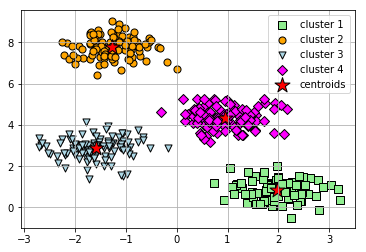

In [35]:
# Plotting along with the Centroids

plt.scatter(X[clusters == 0, 0], X[clusters == 0, 1], s=50, c='lightgreen', marker='s',edgecolor='black', label='cluster 1')
plt.scatter(X[clusters == 1, 0], X[clusters == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster 2')
plt.scatter(X[clusters == 2, 0], X[clusters == 2, 1], s=50, c='lightblue', marker='v', edgecolor='black', label='cluster 3')
plt.scatter(X[clusters == 3, 0], X[clusters == 3, 1], s=50, c='magenta', marker='D', edgecolor='black', label='cluster 4')
plt.scatter(nCenters[:, 0], nCenters[:, 1], s=250, marker='*', c='red', edgecolor='black', label='centroids')
plt.legend()
plt.grid()
plt.show()


    (2b) Implement the `k-means++` initialization method

    (2c) Run your k-means algorithm implementation using the blob dataset from (1) in the following conditions. Choose the reasonable number of runs and maximum iterations from a trial and error. 

    (2c-1) Choose an optimal number of clusters between 1 and 10 based on both the elbow method and silhouette method

In [6]:
# import silhouette plots
from matplotlib import cm
from sklearn.metrics import silhouette_samples

    (2c-2) Set the optimal number of cluseters found from (2c-1) and compare the results of clustering analysis 

    (2c-3) Compare the results of your implementation and results of the scikit-learn implementation for both (2c-1) and (2c-2)

### * results of the scikit-learn implementation

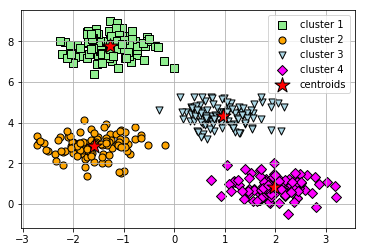

In [33]:
# the scikit-learn implementation
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, init='k-means++', n_init=1, max_iter=1, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0], X[y_km == 0, 1], s=50, c='lightgreen', marker='s',edgecolor='black', label='cluster 1')
plt.scatter(X[y_km == 1, 0], X[y_km == 1, 1], s=50, c='orange', marker='o', edgecolor='black', label='cluster 2')
plt.scatter(X[y_km == 2, 0], X[y_km == 2, 1], s=50, c='lightblue', marker='v', edgecolor='black', label='cluster 3')
plt.scatter(X[y_km == 3, 0], X[y_km == 3, 1], s=50, c='magenta', marker='D', edgecolor='black', label='cluster 4')
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black', label='centroids')
plt.legend()
plt.grid()
plt.show()

In [34]:
print(km.cluster_centers_)
print(nCenters)

[[-1.26551713  7.7693112 ]
 [-1.58634775  2.87759277]
 [ 0.96739668  4.35516475]
 [ 1.97306689  0.84915787]]
[[ 1.9730669   0.84915787]
 [-1.2655171   7.7693114 ]
 [-1.599209    2.8600628 ]
 [ 0.9547205   4.357919  ]]


In [9]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 194.51


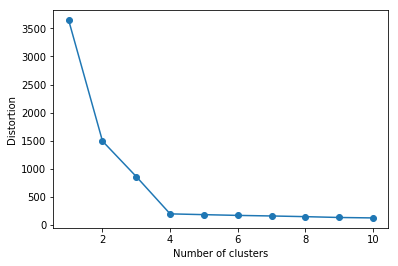

In [10]:
# elbow method
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=1, max_iter=1, tol=1e-04, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

* Cluster number 4 is good choice because as we can see in the following plot, the elbow is located at number 4, which is evidence that number 4 is indeed a good choice for this dataset.

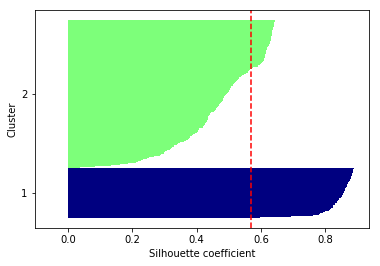

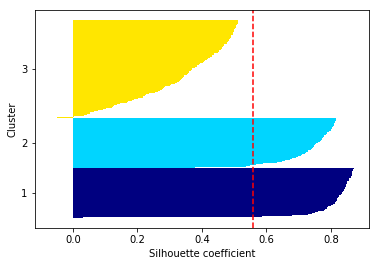

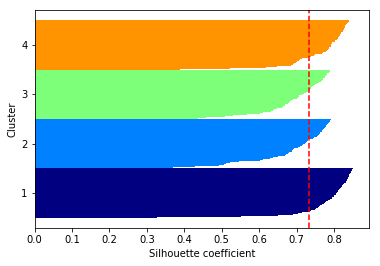

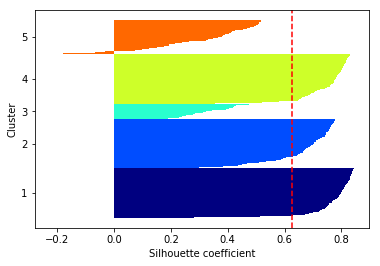

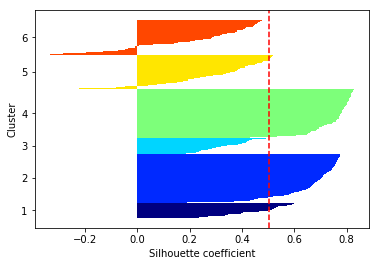

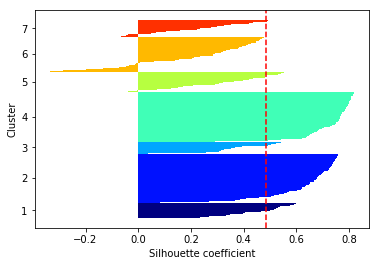

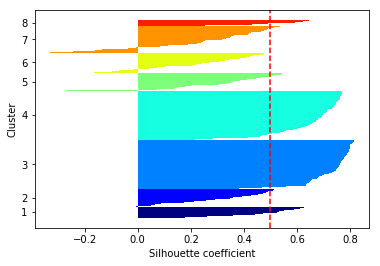

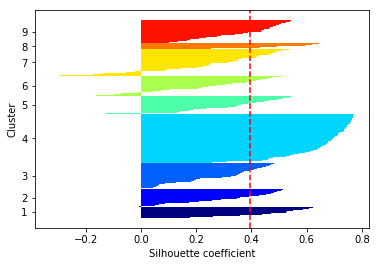

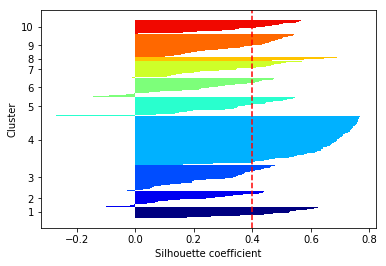

In [11]:
# silhouette method
for i in range(2, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=1, max_iter=1, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

* Cluster number 4 is good choice because not only width and length are the similar each of them but also coefficients are not even close to 0.

##### (3) Fuzzy C-means (FCM)
    (3a) Implement the FCM using generic python code

    (3b) Let's suppose the fuzziness coefficient, m = 2. Choose the proper number of clusters between 1 and 10 based on the elbow method 

    (3c) Discuss the obtained results with the results from (2c-1)